In [54]:
import os

import numpy as np
import cv2   as cv

import matplotlib.pyplot as plt

from matplotlib.pyplot   import imshow, subplot, title, plot

from ipywidgets          import interactive

%matplotlib inline

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread(file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def imshowg(x):
    imshow(x, "gray")

# para imprimir arrays con el número de decimales deseados
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)

def sharr(a, prec=3):
    with printoptions(precision=prec, suppress=True):
        print(a)
               
### HERRAMIENTAS

def desp(d):
    dx,dy = d
    return np.array([
            [1,0,dx],
            [0,1,dy],
            [0,0,1]])

pi = np.pi
degree = pi/180

In [55]:
rutas_list = [
    '../tickets_imagenes/181010_carreforur_conflash_1.JPG',
    '../tickets_imagenes/181010_carreforur_conflash_2.JPG',
    '../tickets_imagenes/181010_carreforur_conflash_3.JPG', 
]

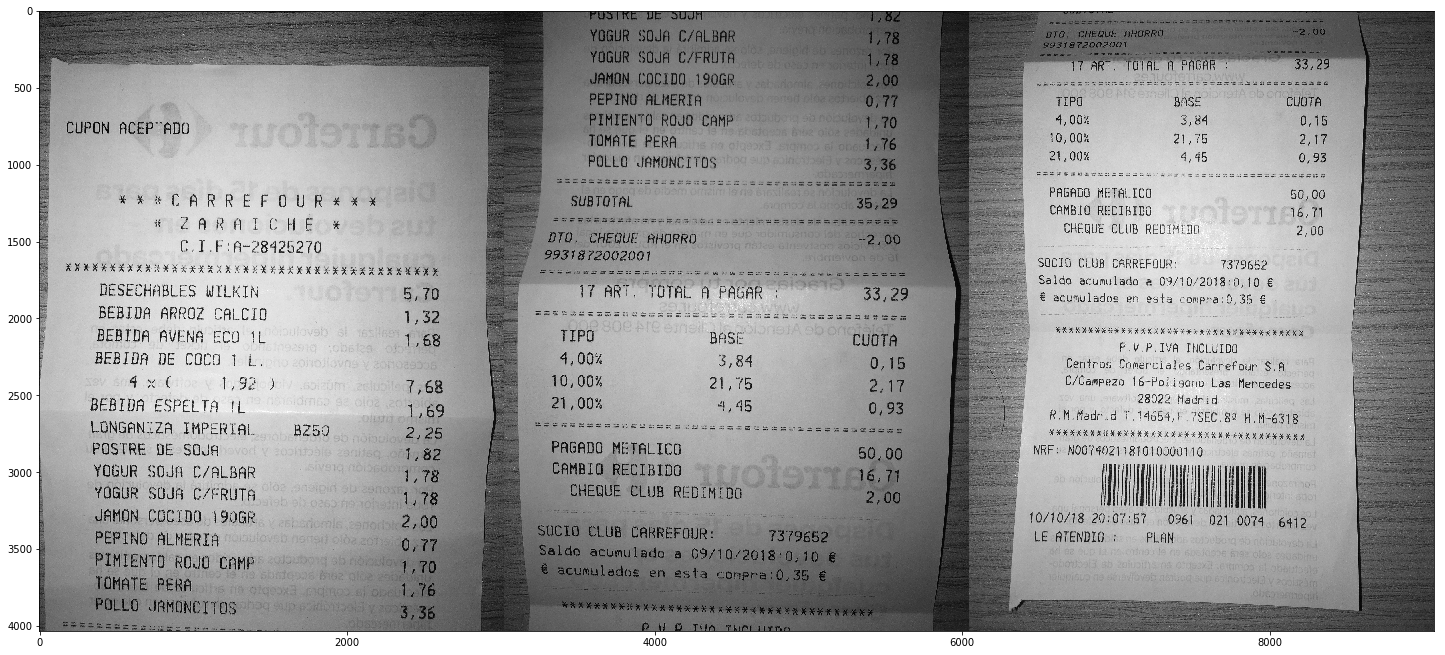

In [59]:
rgb_list = []
images_list = []
for index, item in enumerate(rutas_list):
    rgb_list.append(readrgb(item))
    images_list.append(rgb2gray(rgb_list[index]))
#rgb1 = readrgb('../tickets_imagenes/181010_carreforur_conflash_1.JPG')
#rgb2 = readrgb('../tickets_imagenes/181010_carreforur_conflash_2.JPG')
#rgb3 = readrgb('../tickets_imagenes/181010_carreforur_conflash_3.JPG')
#x1 = rgb2gray(rgb1)
#x2 = rgb2gray(rgb2)
#x3 = rgb2gray(rgb3)

fig(25,25)
imshowg(np.hstack(images_list));

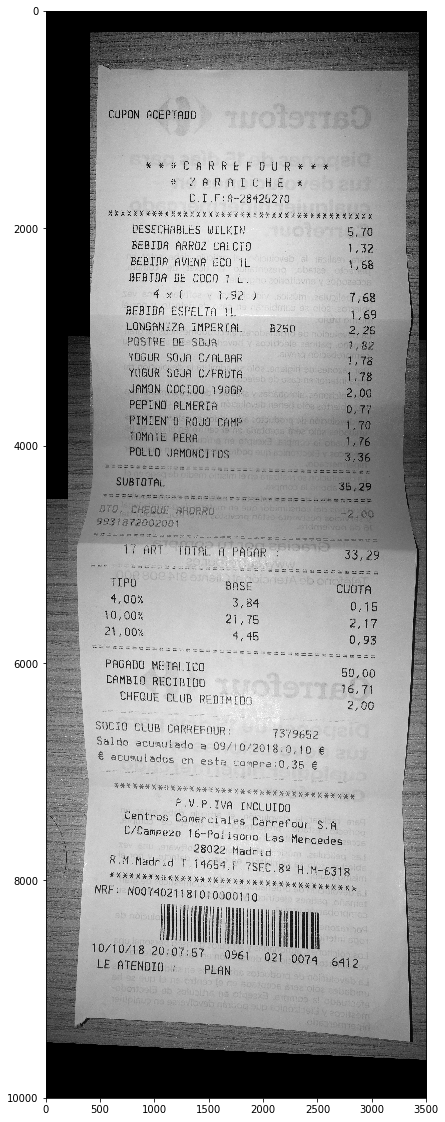

In [60]:
# Creamos el objeto BFMatcher para encajar los descriptores hallados en el paso anterior
# ver https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html
bf = cv.BFMatcher()

matches_list = []
good_list = []
matches_images_list = []
ok_matches_images_list = []
src_dst_list = []
H_list = []
result_images_list = []
def t(h,x):
    return cv.warpPerspective(x, desp((200,100)) @ h,(3500,10000))
if len(images_list) < 2:
    print("minimum 2 images")
sift = cv.xfeatures2d.SIFT_create(contrastThreshold=0.1, edgeThreshold=10)
for index, item in enumerate(images_list):
    # Comprobación de penúltima iteración.
    if index == len(images_list) - 1: 
        continue
    # inicialización de valores para iteración actual
    image1 = images_list[index]
    image2 = images_list[index+1]
    (kps1, descs1) = sift.detectAndCompute(image1, None)
    (kps2, descs2) = sift.detectAndCompute(image2, None)
    
    # determinamos el máximo valor
    #max_val = (image1, kps1, descs1) if len(kps1) > len(kps2) else (image2, kps2, descs2)
    #min_val = (image1, kps1, descs1) if len(kps1) < len(kps2) else (image2, kps2, descs2)
    min_val = (image1, kps1, descs1)
    max_val = (image2, kps2, descs2)
    
    # hacemos el cálculo y lo añadimos a la lista de matches
    matches_list.append(bf.knnMatch(min_val[2],max_val[2],k=2))
    

    #for idx, item in enumerate(matches_list):
    #print(index)
    #print(good_list)
    good_list.append([])
    for m,n in matches_list[-1]:
        if m.distance < 0.75*n.distance:   
            good_list[index].append(m)

    # print(len(good))

    # drawMatches usa la estructura matches1to2
    matches_images_list.append(
        cv.drawMatches(
            min_val[0],min_val[1],
            max_val[0],max_val[1],
            good_list[index],
            flags=2,outImg=None,
            matchColor=(128,0,0)
        )
    )

    src_pts = np.array([ max_val[1][m.trainIdx].pt for m in good_list[index] ]).astype(np.float32).reshape(-1,2)
    dst_pts = np.array([ min_val[1][m.queryIdx].pt for m in good_list[index] ]).astype(np.float32).reshape(-1,2)

    H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 3)
    matchesMask = mask.ravel()>0
    ok = [ good_list[index][k] for k in range(len(good_list[index])) if matchesMask[k] ]
    ok_matches_images_list.append(
        cv.drawMatches(
            min_val[0],min_val[1],max_val[0],max_val[1],ok,flags=2,outImg=None,matchColor=(0,255,0)))
    H_list.append(H)

    result_images_list.append(np.maximum(t(np.eye(3),images_list[index]), t(H,images_list[index+1])))
    images_list[index+1] = np.maximum(t(np.eye(3),images_list[index]), t(H,images_list[index+1]))
#    imshowg(np.maximum(t(np.eye(3),images_list[0]), t(H,images_list[1])));

fig(20,20)
imshowg(result_images_list[-1])



In [58]:
basename = os.path.basename('.')
cv.imwrite('../tickets_imagenes/output.jpg', result_images_list[-1])

True